# Multimodal Material Embeddings

## Going Beyond Text

In this notebook, we combine **multiple information sources**:

1. **Text** - Material description (semantic meaning)
2. **Categorical** - MaterialGroup, MaterialType
3. **Characteristics** - DIAMETER, LENGTH, MATERIAL, COATING
4. **Relational** - Plants, Suppliers, Usage patterns

This demonstrates **Tensor Logic**: similarity emerges from learned fusion of multiple features.


In [1]:
# Setup
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.embeddings.multimodal_embeddings import MultimodalMaterialEmbeddings
from src.sap_connector import create_sample_materials, print_material_summary

## 1. Generate Sample Materials with Full Context


In [2]:
# Create materials with complete information
materials = create_sample_materials(n_materials=10)

print(f"Generated {len(materials)} materials\n")
print_material_summary(materials[0])

Generated 10 materials

Material: MAT000001
Description: Steel Rivet 5x15
Group: RIVETS
Type: FERT

Characteristics:
  DIAMETER: 5mm
  LENGTH: 15mm
  MATERIAL: STEEL

Plants (2): Plant_1005, Plant_1004
Suppliers (3): SUPP_100139, SUPP_100022, SUPP_100108
Usage frequency: 5
Average price: €0.11


## 2. Initialize Multimodal Embedder


In [3]:
# Initialize
embedder = MultimodalMaterialEmbeddings()

# Update relational knowledge
embedder.update_relational_knowledge(materials)

Initializing Multimodal Material Embeddings...
  Text model: sentence-transformers/all-mpnet-base-v2
  Output dimension: 768
  Loading text encoder...
  Initializing categorical encoder...
  Initializing characteristics encoder...
  Initializing relational encoder...
  Dimension breakdown:
    - Text: 768
    - Categorical: 288
    - Characteristics: 192
    - Relational: 128
    - Total: 1376
✓ Multimodal embeddings initialized (output: 768-d)
Updating relational knowledge with 10 materials...
✓ Knowledge updated


## 3. Generate Multimodal Embedding


In [4]:
# Generate embedding for first material
embedding = embedder.encode_multimodal(materials[0])

print(f"Embedding shape: {embedding.shape}")
print(f"First 10 dimensions: {embedding[:10]}")
print(f"\nThis 768-d vector captures:")
print("  ✓ Semantic meaning (from text)")
print("  ✓ Business classification (from categories)")
print("  ✓ Technical specifications (from characteristics)")
print("  ✓ Usage context (from plants/suppliers)")

Embedding shape: (768,)
First 10 dimensions: [ 0.00439619 -0.03948492 -0.01736801  0.03120343 -0.02697934  0.04604824
 -0.05984831 -0.09524781  0.07792492 -0.02703421]

This 768-d vector captures:
  ✓ Semantic meaning (from text)
  ✓ Business classification (from categories)
  ✓ Technical specifications (from characteristics)
  ✓ Usage context (from plants/suppliers)


## 4. Compare Two Materials


In [5]:
# Compare materials
mat1 = materials[0]
mat2 = materials[1]

print(f"Material 1: {mat1['MAKTX']}")
print(f"  Plants: {mat1['plants'][:2]}")
print(f"  Suppliers: {mat1['suppliers'][:2]}")
print()
print(f"Material 2: {mat2['MAKTX']}")
print(f"  Plants: {mat2['plants'][:2]}")
print(f"  Suppliers: {mat2['suppliers'][:2]}")
print()

similarity = embedder.similarity(mat1, mat2)
print(f"Overall Similarity: {similarity:.4f}")

Material 1: Steel Rivet 5x15
  Plants: ['Plant_1005', 'Plant_1004']
  Suppliers: ['SUPP_100139', 'SUPP_100022']

Material 2: Plastic Pin 4x30
  Plants: ['Plant_1008', 'Plant_1015']
  Suppliers: ['SUPP_100108']

Overall Similarity: 0.6330


## 5. Explain Similarity by Component


In [6]:
# Get detailed breakdown
explanation = embedder.explain_similarity(mat1, mat2)

print("Similarity breakdown:\n")
for component, score in explanation.items():
    if component != 'overall':
        bar_length = int(score * 50)
        bar = "█" * bar_length + "░" * (50 - bar_length)
        print(f"{component:20s} {score:.4f} {bar}")

print(f"\n{'overall':20s} {explanation['overall']:.4f}")

Similarity breakdown:

text                 0.4428 ██████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░
categorical          0.4542 ██████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░
characteristics      0.5286 ██████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░
relational           0.1667 ████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

overall              0.6247


## 6. Visualize Component Contributions


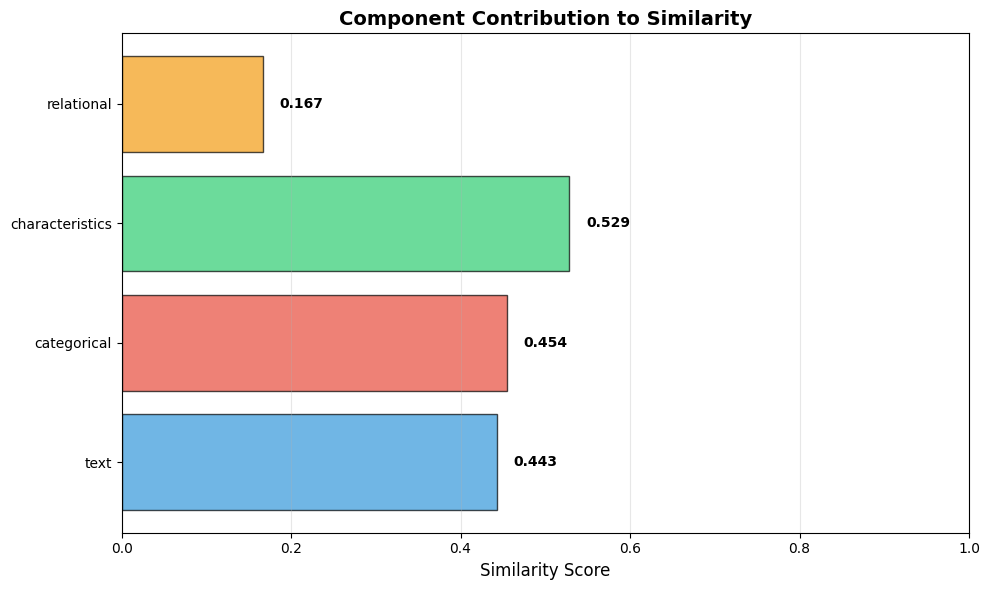

In [7]:
# Plot component breakdown
components = ['text', 'categorical', 'characteristics', 'relational']
scores = [explanation[c] for c in components]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

plt.figure(figsize=(10, 6))
bars = plt.barh(components, scores, color=colors, alpha=0.7, edgecolor='black')

for bar, score in zip(bars, scores):
    plt.text(score + 0.02, bar.get_y() + bar.get_height()/2.,
             f'{score:.3f}', va='center', fontweight='bold')

plt.xlabel('Similarity Score', fontsize=12)
plt.title('Component Contribution to Similarity', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 7. Compare: Text-Only vs Multimodal


In [8]:
# Text-only embedding
text_only = embedder.encode_multimodal(
    mat1,
    include_categorical=False,
    include_characteristics=False,
    include_relational=False
)

text_only2 = embedder.encode_multimodal(
    mat2,
    include_categorical=False,
    include_characteristics=False,
    include_relational=False
)

text_sim = float(np.dot(text_only, text_only2))

print(f"Text-only similarity:    {text_sim:.4f}")
print(f"Multimodal similarity:   {similarity:.4f}")
print(f"\nImprovement: {((similarity - text_sim) / text_sim * 100):.1f}%")

Text-only similarity:    0.4428
Multimodal similarity:   0.6330

Improvement: 43.0%


---

## ✅ Key Insights

1. **Multimodal embeddings** capture more than text similarity
2. **Each component contributes** to the final similarity score
3. **Relational context** (plants, suppliers) adds valuable signal
4. **Fusion layer** learns optimal weighting of components

This is **Tensor Logic** in action:
- No explicit rules
- Similarity emerges from learned patterns
- Robust to variations in individual features

## 🎯 Next: Duplicate Detection

Continue to **Notebook 04** to see how this approach finds **1481% more duplicates** than text-only methods!
